In [1]:
import os
import sys
import glob
import time
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

%matplotlib inline

In [2]:
from utils import convert_tensor_to_PIL, show_imgs
from dataset import Dataset

from unet import UNet
from fcn import *

In [8]:
MODEL_PATH = 'models/UCSDped1/'
DATA_DIR = 'data/UCSD_Anomaly_Dataset.v1p2/UCSDped1/'
TRAIN_PATTERN = os.path.join(DATA_DIR, 'Train/*/*.tif')
train_paths = sorted(glob.glob(TRAIN_PATTERN))

In [29]:
default_size = Image.open(train_paths[0]).size

# (112, 112)

## Training

In [10]:
# hyperparams
gamma = 0.4
batch_size = 16
num_epochs = 30
print_intv = 1

In [14]:
g_lr = 1e-4
d_lr = 2e-5

In [15]:
train_dataset = Dataset(train_paths, (112, 112))
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

G = UNet(1, 1).to(device)
D = FCN_112_11(1).to(device)
G_optimizer = optim.Adam(G.parameters(), lr=g_lr)
D_optimizer = optim.Adam(D.parameters(), lr=d_lr)
criterion = nn.BCEWithLogitsLoss()

Epoch 0: 4.9min, D_loss: 1.158832, G_loss: 0.855280


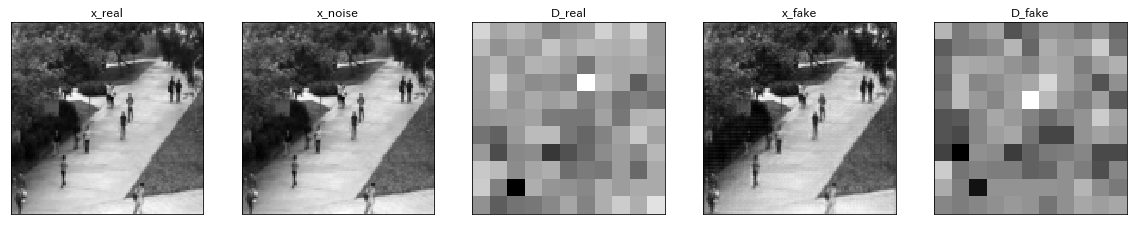

Epoch 1: 4.9min, D_loss: 1.389307, G_loss: 0.692252


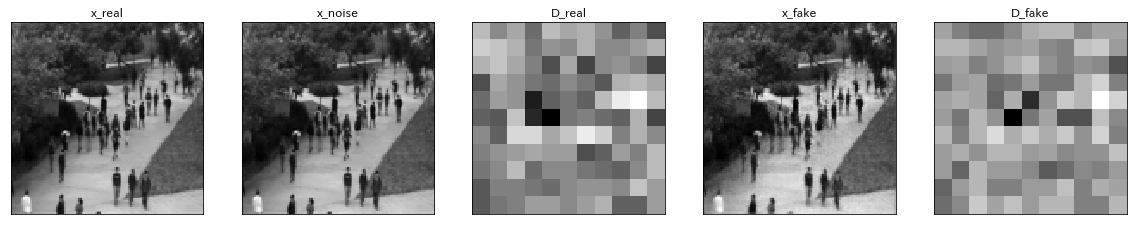

Epoch 2: 4.9min, D_loss: 1.387865, G_loss: 0.693451


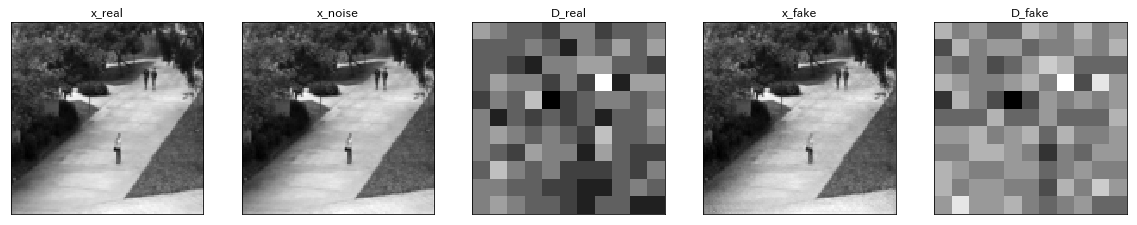

Epoch 3: 4.9min, D_loss: 1.386818, G_loss: 0.693977


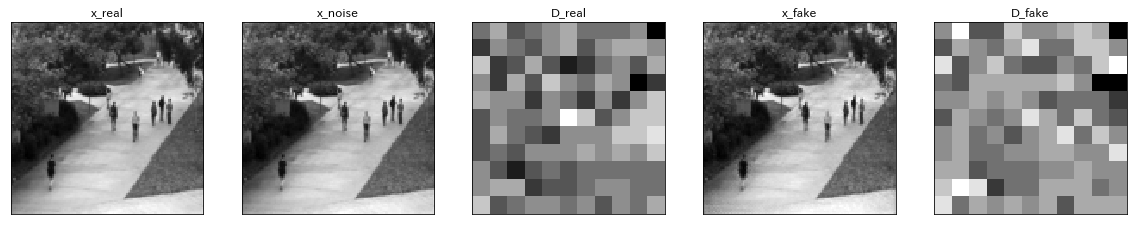

Epoch 4: 4.9min, D_loss: 1.386063, G_loss: 0.694939


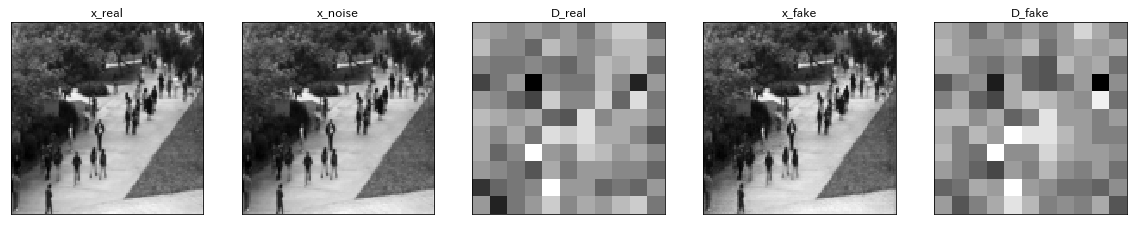

Epoch 5: 5.0min, D_loss: 1.386810, G_loss: 0.694302


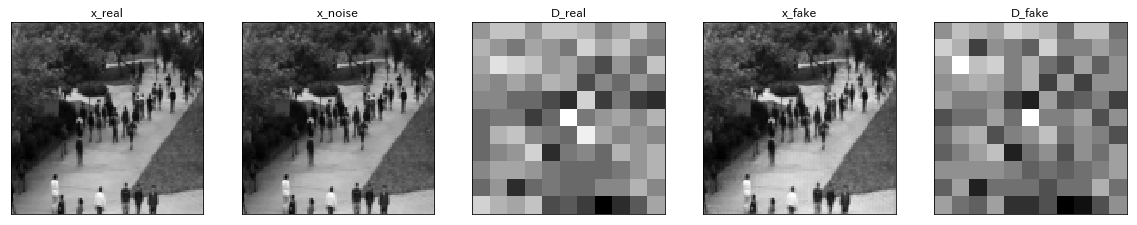

Epoch 6: 4.9min, D_loss: 1.386845, G_loss: 0.694028


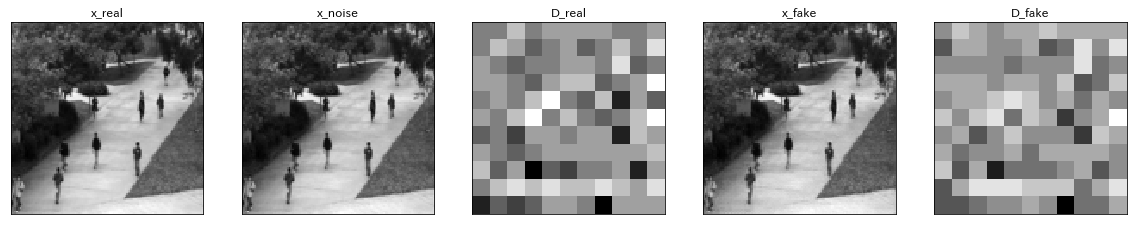

Epoch 7: 4.9min, D_loss: 1.386804, G_loss: 0.693734


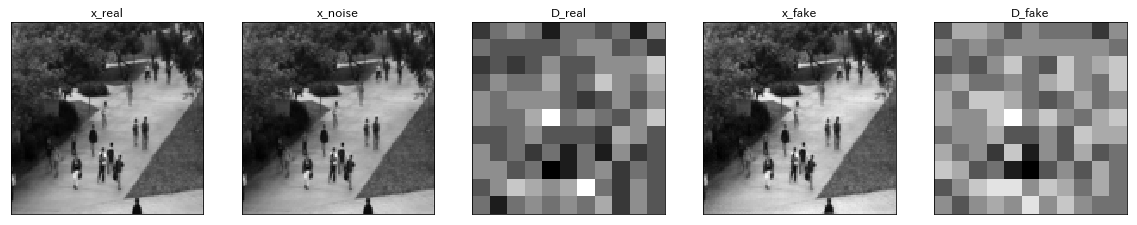

Epoch 8: 4.9min, D_loss: 1.386907, G_loss: 0.694172


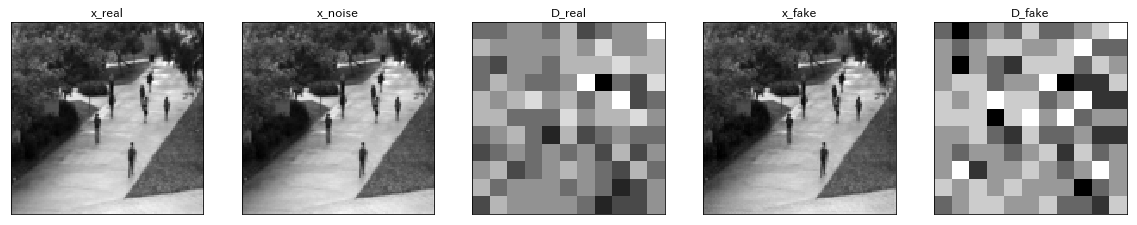

Epoch 9: 4.9min, D_loss: 1.386913, G_loss: 0.693526


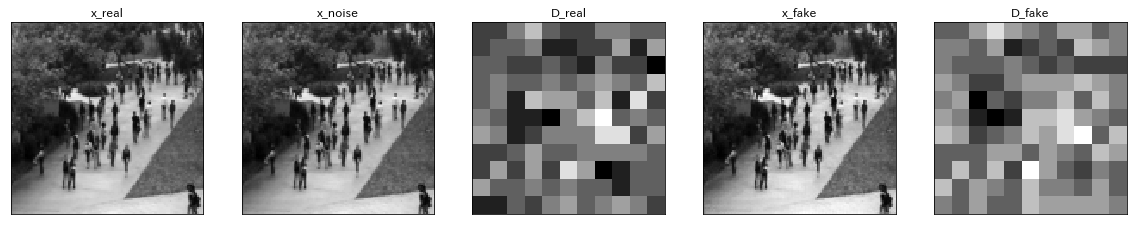

Epoch 10: 4.9min, D_loss: 1.386756, G_loss: 0.693678


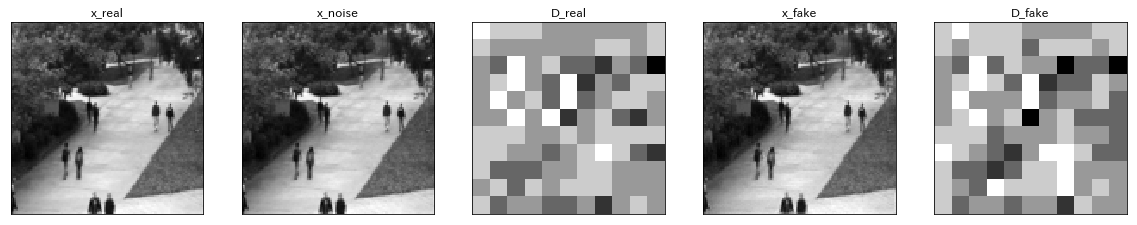

Epoch 11: 5.0min, D_loss: 1.386743, G_loss: 0.693505


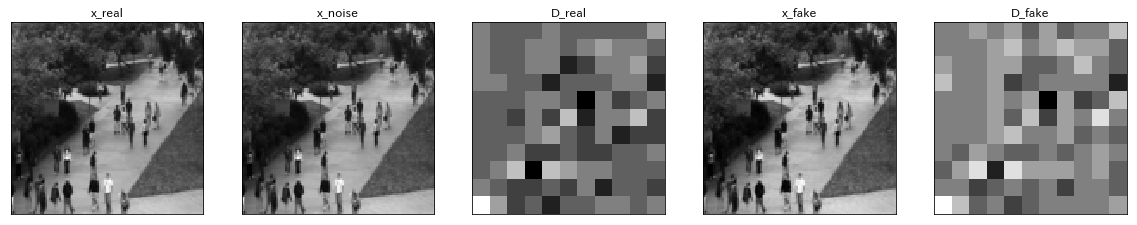

Epoch 12: 4.9min, D_loss: 1.386685, G_loss: 0.694095


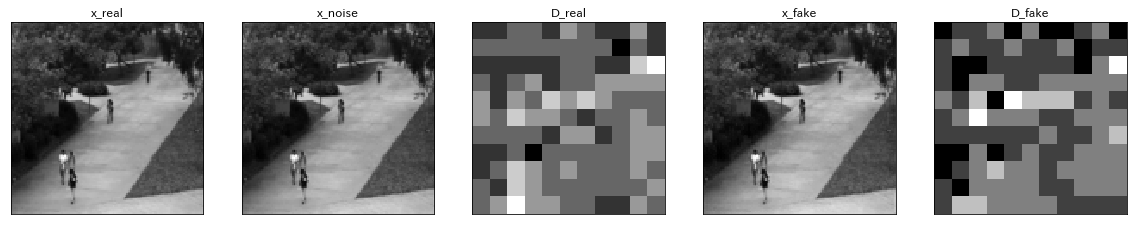

Epoch 13: 4.9min, D_loss: 1.386677, G_loss: 0.693800


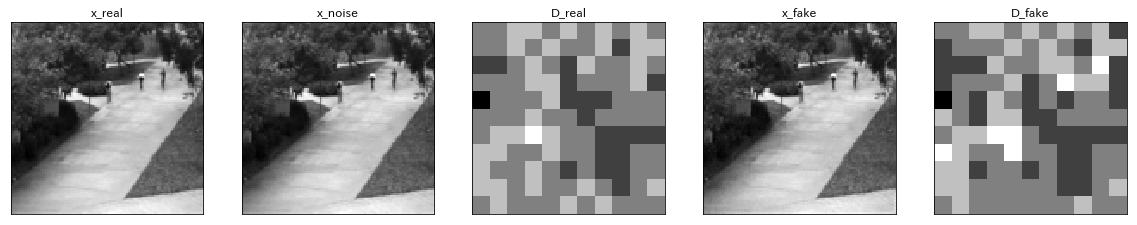

Epoch 14: 4.9min, D_loss: 1.386814, G_loss: 0.694191


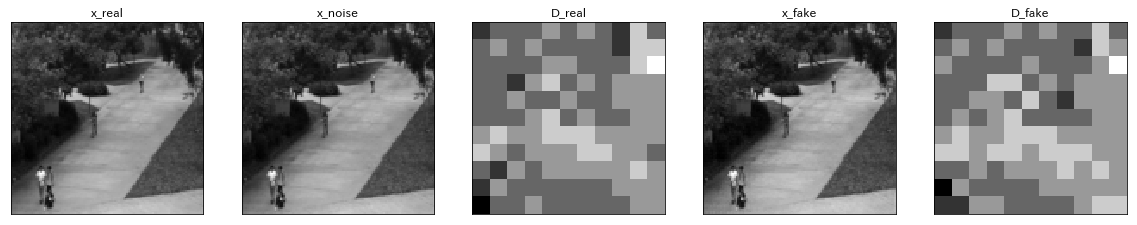

KeyboardInterrupt: 

In [16]:
# Training
history = {'D_loss': [], 'G_loss': []}

D.train()
G.train()
D_best_loss = np.inf
G_best_loss = np.inf

for epoch in range(num_epochs):
    D_running_loss = 0
    G_running_loss = 0
    _D_real_loss = 0
    _D_fake_loss = 0
    
    start = time.time()
    for x_real in train_loader:

        D.zero_grad()
        G.zero_grad()
        D_optimizer.zero_grad()
        G_optimizer.zero_grad()
        
        x_real = x_real.to(device) 

        ### Update Discriminator ###
        # real
        D_real = D(x_real)
        y_real = torch.ones(D_real.size()).to(device)
        y_fake = torch.zeros(D_real.size()).to(device)
        D_real_loss = criterion(D_real, y_real)
        
        # fake
        eta = torch.randn(x_real.size()).to(device)
        x_noise = x_real + gamma * eta / 255
        x_fake = G(x_noise)
        D_fake = D(x_fake.detach())  # detach for computational speed
        D_fake_loss = criterion(D_fake, y_fake)
        
        # update params
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()
        D_running_loss += D_loss.item()
        # for debug
        _D_real_loss += D_real_loss.item()
        _D_fake_loss += D_fake_loss.item()
        
        ### Update Generator ###
        eta = torch.randn(x_real.size()).to(device)
        x_noise = x_real + gamma * eta / 255
        x_fake = G(x_noise)
        D_fake = D(x_fake)
        
        # update params
        G_loss = criterion(D_fake, y_real)
        G_loss.backward()
        G_optimizer.step()
        G_running_loss += G_loss.item()
    
    elapsed_time = (time.time() - start) / 60
    
    D_running_loss /= len(train_loader)
    G_running_loss /= len(train_loader)
    history['D_loss'].append(D_running_loss)
    history['G_loss'].append(G_running_loss)
    
    torch.save(D.state_dict(), MODEL_PATH+'D_{:03d}.pth'.format(epoch))
    torch.save(G.state_dict(), MODEL_PATH+'G_{:03d}.pth'.format(epoch))
    
    if D_running_loss < D_best_loss:
        D_best_loss = D_running_loss
        torch.save(D.state_dict(), MODEL_PATH+'D.pth'.format(epoch))
    if G_running_loss < G_best_loss:
        G_best_loss = G_running_loss
        torch.save(G.state_dict(), MODEL_PATH+'G.pth')
    
    print('Epoch {}: {:.1f}min, D_loss: {:.6f}, G_loss: {:.6f}'.format(epoch, elapsed_time, D_running_loss, G_running_loss))
    
    if epoch % print_intv == 0:
        imgs = {
            'x_real': (x_real + 1) / 2,
            'x_noise': (x_noise + 1) / 2,
            'D_real': torch.sigmoid(D_real),
            'x_fake': (x_fake + 1) / 2,
            'D_fake': torch.sigmoid(D_fake),
        }        
        idxs = np.random.randint(0, x_real.size(0), [1])
        show_imgs(imgs, idxs)

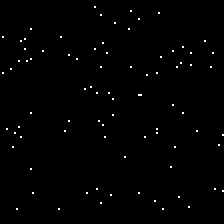

In [17]:
diff = x_real - x_noise
convert_tensor_to_PIL(diff[0]).resize([224,224])

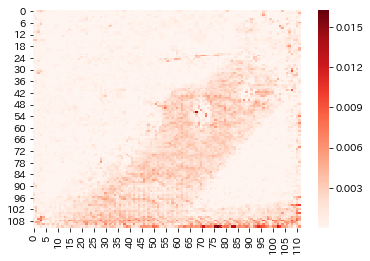

In [19]:
diff = torch.pow(x_real-x_fake, 2)
sns.heatmap(diff.data.cpu().numpy()[0,0], cmap='Reds')

## 推論

In [21]:
TEST_PATTERN = os.path.join(DATA_DIR, 'Test/*/*.tif')
test_paths = glob.glob(TEST_PATTERN)
test_dataset = Dataset(test_paths, (112, 112))
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False)

In [22]:
for x_path, x_real in zip(test_paths, test_loader):
    break

### 正常

In [52]:
x_path = DATA_DIR + 'Test/Test003/130.tif'
x_gt_path = DATA_DIR + 'Test/Test003_gt/130.bmp'

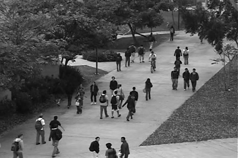

In [62]:
img = Image.open(x_path)
img

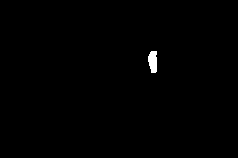

In [53]:
Image.open(x_gt_path)

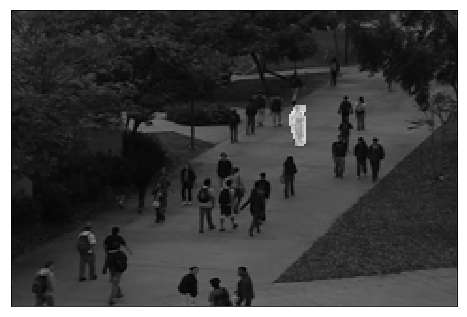

In [58]:
plt.figure(figsize=[8,8])
plt.imshow(Image.open(x_path), cmap='gray')
plt.imshow(Image.open(x_gt_path), cmap='gray', alpha=0.5)
plt.xticks([])
plt.yticks([])
plt.show()

In [63]:
x_real = img.convert('L')
x_real = train_dataset.transform(x_real)
x_real = x_real.unsqueeze(0)
x_real = x_real.to(device)

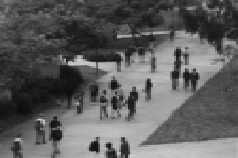

In [64]:
_x_real = (x_real[0].cpu() + 1) / 2
transforms.ToPILImage()(_x_real).resize(default_size)

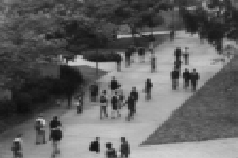

In [65]:
x_fake = G(x_real)
_x_fake = (x_fake[0].cpu() + 1) / 2
transforms.ToPILImage()(_x_fake).resize(default_size)

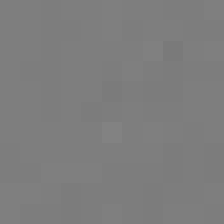

In [66]:
D_real = torch.sigmoid(D(x_real))
transforms.ToPILImage()(D_real[0].cpu()).resize((224,224))

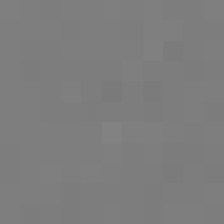

In [67]:
D_fake = torch.sigmoid(D(x_fake))
transforms.ToPILImage()(D_fake[0].cpu()).resize((224,224))

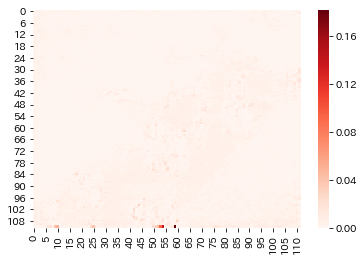

In [68]:
diff = torch.pow(x_real-x_fake, 2)
sns.heatmap(diff.data.cpu().numpy()[0,0], cmap='Reds')